In [5]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [15]:
parameters = {'kernel':['rbf'],
              'C':[0.05 ,0.5, 1, 5, 10, 50, 100, 500, 1000],
              'epsilon':[0.1,0.01,0.001, 0.0001]}

In [28]:
def GridSearch(rf, X_train, X_test, y_train, y_test, grid, verbose=False, skip=False):
    best_score = -10
    par = ParameterGrid(grid)
    ln = len(par)
    i = 0
    for g in par:
        if skip and i == 46:
            continue
        if(verbose):
            print(f"Probando: {g}, {i} de {ln}")
        i+=1
        rf.set_params(**g)
        startTime = time.time()
        rf.fit(X_train, np.ravel(y_train))
        elapsedTime = time.time() - startTime
        score = rf.score(X_test, y_test)
        if(verbose):
            print(f"Tiempo de entrenamiento: {elapsedTime} s, score: {score}")
        # save if best
        if score > best_score:
            best_score = score
            best_grid = g
    print(f"Best Score: {best_score}")
    print(f"Best Parameters: {best_grid}")
    return best_grid

In [35]:
Year_to_separate = 2010
df = pd.read_parquet("dataset.parquet")
df = df[df.COU == 'DNK']
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [36]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.05, 'epsilon': 0.1, 'kernel': 'rbf'}, 0 de 36
Tiempo de entrenamiento: 0.0017085075378417969 s, score: -53.24378083609009
Probando: {'C': 0.05, 'epsilon': 0.01, 'kernel': 'rbf'}, 1 de 36
Tiempo de entrenamiento: 0.001325845718383789 s, score: -43.56803309515911
Probando: {'C': 0.05, 'epsilon': 0.001, 'kernel': 'rbf'}, 2 de 36
Tiempo de entrenamiento: 0.0015552043914794922 s, score: -42.48194626059905
Probando: {'C': 0.05, 'epsilon': 0.0001, 'kernel': 'rbf'}, 3 de 36
Tiempo de entrenamiento: 0.0014302730560302734 s, score: -42.571850499002004
Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 4 de 36
Tiempo de entrenamiento: 0.004775524139404297 s, score: -29.541362417524894
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 5 de 36
Tiempo de entrenamiento: 0.003581523895263672 s, score: -34.65416091994533
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 6 de 36
Tiempo de entrenamiento: 0.0038247108459472656 s, score: -35.530031245052214
Probando: {'C'

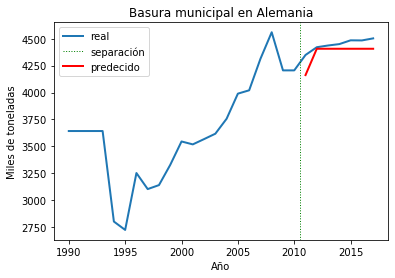

1.7433057547973827


In [41]:
country = 'DNK'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Alemania")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).mean() * 100)
deu2000 = predictions

,Country,Year,COU,Built,Below Secundary,Income Median,Population,Over 65,Over 65 Percentage,Over 85,...,Income Per Capita,Tourism,Area,Built Area,Municipal,Household,Recovered,Recicled,Compost,Disposal
224,Germany,1990,DEU,6.17724,21.615114,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,21765.751549,7.23,356970.0,2.205089e+06,49857.0,26828.0,26853.00,8232.00,6516.00,7539.00
225,Germany,1991,DEU,6.17724,18.184790,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,23471.161739,7.23,356970.0,2.205089e+06,49857.0,26828.0,26853.00,8232.00,6516.00,7539.00
226,Germany,1992,DEU,6.17724,18.084284,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,24308.714644,7.23,356970.0,2.205089e+06,49857.0,26828.0,26853.00,8232.00,6516.00,7539.00
227,Germany,1993,DEU,6.17724,18.084284,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,24505.183034,7.23,356990.0,2.205213e+06,49857.0,24203.0,10641.00,8628.00,2013.00,19906.00
228,Germany,1994,DEU,6.17724,15.993667,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,25565.174206,7.23,357000.0,2.205275e+06,49857.0,24203.0,10641.00,8628.00,2013.00,19906.00
229,Germany,1995,DEU,6.17724,16.322004,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,26449.357105,7.23,357020.0,2.205398e+06,50893.9,24203.0,20118.14,13384.47,6678.46,30775.76
230,Germany,1996,DEU,6.17724,16.322004,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,27053.124340,7.23,357030.0,2.205460e+06,52544.0,35129.0,22227.53,15042.78,7129.46,30316.47
231,Germany,1997,DEU,6.17724,16.763416,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,27674.032035,7.23,357030.0,2.205460e+06,53966.0,36211.0,23859.42,16432.92,7368.19,30106.58
232,Germany,1998,DEU,6.17724,16.236273,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,28579.749314,7.23,357030.0,2.205460e+06,53058.0,35871.0,24229.08,16527.55,7640.24,28828.92
233,Germany,1999,DEU,6.17724,18.763994,22421.263641,66829563.0,12998929.0,0.194509,2114164.0,...,29675.128646,7.23,357030.0,2.205460e+06,52373.0,39093.0,26873.67,19897.95,6883.00,25499.33
